## Testing CV implementation in sunpy.map.rotate

In [1]:
import sunpy.data.sample
import sunpy.map
import skimage
import scipy
import numpy as np
import astropy
import cv2
import pyinstrument
from pyinstrument import Profiler
import sunpy.data.sample
import sunpy.map

In [2]:
#dev code
print(sunpy.__version__)
print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)
print(astropy.__version__)
print(cv2.__version__)
print(pyinstrument.__version__)

2.1.dev341+gf35e21e40.d20200910
1.19.1
0.17.2
1.5.2
4.0.1.post1
4.4.0
3.2.0


In [16]:
aia_map2 = sunpy.map.Map(sunpy.data.sample.AIA_171_ROLL_IMAGE)
print(aia_map2.rotation_matrix)
# scale factor assumed to be 1.

[[ 0.70734472  0.70686876]
 [-0.70686876  0.70734472]]


In [3]:
profiler_sk = Profiler()
# default skimage
profiler_sk.start()
aia_map2_r_sk = aia_map2.rotate(order=3, recenter=True)
profiler_sk.stop()
print(profiler_sk.output_text(unicode=True, color=True))


  _     ._   __/__   _ _  _  _ _/_   Recorded: 16:34:05  Samples:  1429
 /_//_/// /_\ / //_// / //_'/ //     Duration: 5.315     CPU time: 5.297
/   _/                      v3.2.0

Program: /mnt/c/Users/cmbard/Documents/Science/sun_devo_env/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/cmbard/.local/share/jupyter/runtime/kernel-9f79f792-bc96-47a3-8267-5facb1501174.json

5.315 run_code  IPython/core/interactiveshell.py:3376
└─ 5.315 <module>  <ipython-input-3-f76932ba03ca>:6
   └─ 5.315 wrapper  astropy/units/decorators.py:165
      └─ 5.315 rotate  sunpy/map/mapbase.py:1237
         ├─ 4.468 affine_transform  sunpy/image/transform.py:29
         │  ├─ 3.319 warp  skimage/transform/_warps.py:684
         │  │     [18 frames hidden]  skimage, numpy, <built-in>, <__array_...
         │  │        2.715 [self]  
         │  ├─ 0.745 <module>  skimage/transform/__init__.py:1
         │  │     [678 frames hidden]  skimage, scipy, <built-in>, inspect, ...
         │  ├─ 0.318 nda

In [4]:
profiler_sci = Profiler()
profiler_sci.start()
aia_map2_r_sci = aia_map2.rotate(order=3, recenter=True, use_scipy=True)
profiler_sci.stop()
print(profiler_sci.output_text(unicode=True, color=True))


  _     ._   __/__   _ _  _  _ _/_   Recorded: 16:34:10  Samples:  717
 /_//_/// /_\ / //_// / //_'/ //     Duration: 6.149     CPU time: 6.156
/   _/                      v3.2.0

Program: /mnt/c/Users/cmbard/Documents/Science/sun_devo_env/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/cmbard/.local/share/jupyter/runtime/kernel-9f79f792-bc96-47a3-8267-5facb1501174.json

6.149 run_code  IPython/core/interactiveshell.py:3376
└─ 6.149 <module>  <ipython-input-4-6d5e387d5fb4>:3
   └─ 6.149 wrapper  astropy/units/decorators.py:165
      └─ 6.149 rotate  sunpy/map/mapbase.py:1237
         ├─ 5.307 affine_transform  sunpy/image/transform.py:29
         │  ├─ 5.146 affine_transform  scipy/ndimage/interpolation.py:395
         │  │     [7 frames hidden]  scipy, <built-in>
         │  │        3.865 geometric_transform  <built-in>:0
         │  │        1.281 spline_filter1d  <built-in>:0
         │  ├─ 0.089 [self]  
         │  └─ 0.070 nan_to_num  <__array_function__ internals>:2

In [5]:
profiler_cv = Profiler()
profiler_cv.start()
aia_map2_r_cv = aia_map2.rotate(order=3, recenter=True, use_cv2=True)
profiler_cv.stop()
print(profiler_cv.output_text(unicode=True, color=True))


  _     ._   __/__   _ _  _  _ _/_   Recorded: 16:34:17  Samples:  767
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.196     CPU time: 3.297
/   _/                      v3.2.0

Program: /mnt/c/Users/cmbard/Documents/Science/sun_devo_env/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/cmbard/.local/share/jupyter/runtime/kernel-9f79f792-bc96-47a3-8267-5facb1501174.json

2.196 run_code  IPython/core/interactiveshell.py:3376
└─ 2.196 <module>  <ipython-input-5-60525b2c2a46>:3
   └─ 2.196 wrapper  astropy/units/decorators.py:165
      └─ 2.196 rotate  sunpy/map/mapbase.py:1237
         ├─ 1.307 affine_transform  sunpy/image/transform.py:29
         │  ├─ 0.964 warpAffine  <built-in>:0
         │  │     [2 frames hidden]  <built-in>
         │  ├─ 0.315 ndarray.astype  <built-in>:0
         │  │     [2 frames hidden]  <built-in>
         │  └─ 0.028 _showwarnmsg  warnings.py:96
         │        [13 frames hidden]  warnings, astropy, posixpath, generic...
         ├─ 0.399 ref

Skimage and scipy.ndimage do use different algorithms, so we need a basis for comparison: what is an acceptable margin of difference? Not sure the best way to compare, but I've decided to use the [Symmetric Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) (the third equation in the link):

In [6]:
#SymmetricMeanAbsolutePercentageError
# returns between 0-100% of average error between arr1 and arr2 
def smape(arr1,arr2):
    eps = np.finfo(np.float64).eps
    return ((np.abs(arr1-arr2) / (np.maximum(np.abs(arr1)+np.abs(arr2),eps))).mean() * 100)

def smape_arr(arr1,arr2):
    eps = np.finfo(np.float64).eps
    return ((np.abs(arr1-arr2) / (np.maximum(np.abs(arr1)+np.abs(arr2),eps))) * 100)


In [7]:
print("sk64 vs. sci16",smape(aia_map2_r_sk.data, aia_map2_r_sci.data))
print("sci16 vs. cv64",smape(aia_map2_r_sci.data, aia_map2_r_cv.data))
print("sk64 vs. cv64",smape(aia_map2_r_sk.data, aia_map2_r_cv.data))

sk64 vs. sci16 1.3239767795122241
sci16 vs. cv64 1.2391068491436688
sk64 vs. cv64 0.3998304586831382


This gives me a baseline for what constitutes an "acceptable difference" between the currently implemented results of `rotate` (sk vs. scipy). For the sample map, the SMAPE is ~1.3% between `skimage` and `scipy`. Note, however, that some of the edges of the solar disk (and possibly off-disk) will have differences between \[A NUMBER\] and 0. -> this returns SMAPE = 100% error, but the raw error in those cells is very small. Excluding these cells from the average SMAPE gives us a better understanding of the differences within the solar disk:

In [8]:
arr_diff = smape_arr(aia_map2_r_sk.data, aia_map2_r_sci.data)
print(arr_diff.max(), arr_diff.min()) #should be between 0 and 100
err_full = np.where(arr_diff == 100)
err_exclude_full = np.where(arr_diff != 100)

print("max raw count error in 100% error cells",((np.abs(aia_map2_r_sk.data-aia_map2_r_sci.data))[err_full]).max())
max_raw = np.abs(aia_map2_r_sk.data-aia_map2_r_sci.data).max()
idx_max = np.where(np.abs(aia_map2_r_sk.data-aia_map2_r_sci.data) == max_raw)
print("max raw count error overall and relative % difference in that cell:", max_raw,arr_diff[idx_max])

print("SMAPE sk64 vs. sci16, excluding 100% error cells", arr_diff[err_exclude_full].mean())

100.0 0.0
max raw count error in 100% error cells 17.145475208771714
max raw count error overall and relative % difference in that cell: 992.0 [2.93856271]
SMAPE sk64 vs. sci16, excluding 100% error cells 0.460437068248757


In [9]:
arr_diff = smape_arr(aia_map2_r_cv.data, aia_map2_r_sci.data)
print(arr_diff.max(), arr_diff.min()) #should be between 0 and 100
err_full = np.where(arr_diff == 100)
err_exclude_full = np.where(arr_diff != 100)

print("max raw count error in 100% error cells",((np.abs(aia_map2_r_cv.data-aia_map2_r_sci.data))[err_full]).max())
max_raw = np.abs(aia_map2_r_cv.data-aia_map2_r_sci.data).max()
idx_max = np.where(np.abs(aia_map2_r_cv.data-aia_map2_r_sci.data) == max_raw)
print("max raw count error overall and relative % difference in that cell:", max_raw,arr_diff[idx_max])

print("SMAPE cv64 vs. sci16, excluding 100% error cells", arr_diff[err_exclude_full].mean())

100.0 0.0
max raw count error in 100% error cells 5.0
max raw count error overall and relative % difference in that cell: 524.3956660628319 [1.73915092]
SMAPE cv64 vs. sci16, excluding 100% error cells 0.3792128678292148


In [10]:
arr_diff = smape_arr(aia_map2_r_sk.data, aia_map2_r_cv.data)
print(arr_diff.max(), arr_diff.min()) #should be between 0 and 100
err_full = np.where(arr_diff == 100)
err_exclude_full = np.where(arr_diff != 100)

print("max raw count error in 100% error cells",((np.abs(aia_map2_r_sk.data-aia_map2_r_cv.data))[err_full]).max())
max_raw = np.abs(aia_map2_r_sk.data-aia_map2_r_cv.data).max()
idx_max = np.where(np.abs(aia_map2_r_sk.data-aia_map2_r_cv.data) == max_raw)
print("max raw count error overall and relative % difference in that cell:", max_raw,arr_diff[idx_max])

print("SMAPE sk64 vs. cv64, excluding 100% error cells", arr_diff[err_exclude_full].mean())

100.0 0.0
max raw count error in 100% error cells 8.71999261762325
max raw count error overall and relative % difference in that cell: 1364.4440767765045 [3.99773315]
SMAPE sk64 vs. cv64, excluding 100% error cells 0.34788557627825395


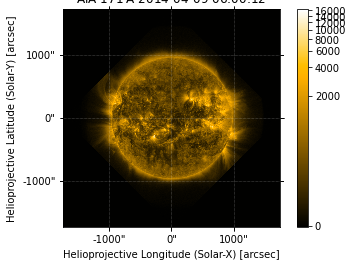

In [11]:
# finally pictures!
aia_map2_r_sk.peek()

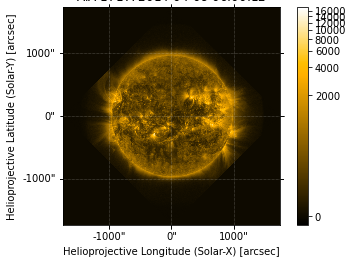

In [12]:
aia_map2_r_sci.peek()

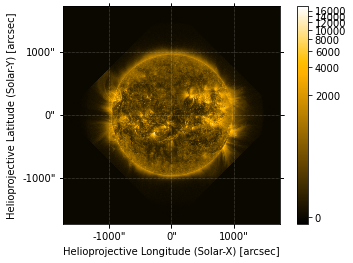

In [13]:
aia_map2_r_cv.peek()